### 1. IMPORT

In [1]:
import pandas as pd
import numpy as np
import openpyxl
import time

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException
from selenium.webdriver.support.ui import WebDriverWait

import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import IntProgress, Box, Label, Layout, interact
from IPython.display import display

import nltk
import re
import googletrans
import python_translator
from langdetect import detect

from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from wordcloud import WordCloud

### 2. FUNCTIONS

#### 2.1 Purple bar to know the progress of the scraping

In [2]:
def prog_bar(part, collection, label = "Processing", it = "", labelwidth = "20%", barwidth = "25%", barcolor = "purple"):
    """
    Purple progress bar
    Input:
        * The code has two parts, one before and the other after the loop.
        * The collection needed to make proportion of progress, from 0 to 100%.
        * Label of the bar as a string. Example: "Extracting Text"
        * Iteration element from collection
        * Label width in string percentage. Ex. "20%"
        * Bar width in string percentage. Ex. "25%"
        * Bar Color. Ex. "Purple"
    """
    global c
    global progress_bar
    if part == 1:
        c = 0
        label = widgets.Label(f'{label} --> ', layout=widgets.Layout(width = labelwidth))
        try:
            progress_bar = IntProgress(min=0,max=collection, style = {'description_width': 'initial'}, 
                                   layout=widgets.Layout(width = barwidth))
        except:
            progress_bar = IntProgress(min=0,max=len(collection), style = {'description_width': 'initial'}, 
                                   layout=widgets.Layout(width = barwidth))
        progress_bar.style.bar_color = barcolor
        return display(widgets.Box(children=[label,progress_bar]))
    
    elif part == 2:
        c += 1
        progress_bar.value += 1
        try:
            progress_bar.description = f"{it}  ({int((c/collection*100))}%)"
        except:
            progress_bar.description = f"{it}  ({int((c/len(collection)*100))}%)"
    else:
        print("There is an error with the indicated part")

### 3. WEBSCRAPING

#### 3.1 HEADER
1. Set the path of chromedriver. Download it from here: https://chromedriver.chromium.org/downloads, regarding your chrome version.
2. Define the position and its location.
3. Set the number of desired job publications, in this case 100.

In [3]:
chromepath = r'D:\PY\5_webscraping\Selenium\chromedriver.exe'
html = 'https://www.linkedin.com/jobs/search'

job_search = "Data scientist"
location_search = "Spain"

# SET NUMBER OF RESULTS
n = 100
# WAITING TIMES
t = 5
SCROLL_PAUSE_TIME = 1.3

#### 3.2 WEBSITES SCRAPING
* This piece of code makes the job search and gets the urls of every publication.<br>
* To do that it solves infinite scrolling.

In [4]:
## AVOID CHROME TO DETECT BEING CONTROLLED FOR A TEST SOFTWARE AND CRASH
chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("excludeSwitches", ['enable-automation'])
# RUN SILENTLY IN BACKGROUND
# chrome_options.add_argument("--headless")

# LOCATE SEARCH BOX IN THE WEB AND TYPE SEARCH CONTENT
if job_search!="":
    driver = webdriver.Chrome(chromepath,options=chrome_options)
    driver.get(html)
    i=0

#### While loop to ensure website started ok and not with a register form
    i=0
    while driver.title.startswith("Registrarse") == True or driver.title.startswith("Sign") == True or driver.title.startswith("www") == True:
        i+=1
        print(f"Try {i}")
        driver.get(html)
        time.sleep(t)
        
    time.sleep(t)
    search1 = driver.find_element_by_name("keywords")    
    # SELECT ALL AND REPLACE CONTENT IN CASE HAVE DEFAULT VALUES
    search1.send_keys(Keys.CONTROL + "a")
    search1.send_keys(job_search)
    
    search2 = driver.find_element_by_name('location')
    search2.send_keys(Keys.CONTROL + "a")
    search2.send_keys(location_search)
    
    search2.send_keys(Keys.RETURN)
    time.sleep(t)
else:
    print("WRITE DESIRED JOB TO SEARCH IN INITIAL SETUP SECTION OF THIS SCRIPT")

##################SCROLL TO THE BOTTOM OF PAGE ###########
driver.current_url

if n > len(driver.find_elements_by_xpath("//li//a[contains(@href,'/jobs/')]")):

    print("Loading web site (infinite scrolling web design)...", end = 2*"\n")

    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")

        if new_height == last_height:
            try:
                driver.find_element_by_xpath("//button[contains(., 'See more jobs')]").click()
                time.sleep(SCROLL_PAUSE_TIME)

                out = []
                while n > len(driver.find_elements_by_xpath("//li//a[contains(@href,'/jobs/')]")):
                    try:
                        driver.find_element_by_xpath("//button[contains(., 'See more jobs')]").click()
                        time.sleep(SCROLL_PAUSE_TIME)
                        if len(out) == len(driver.find_elements_by_xpath("//li//a[contains(@href,'/jobs/')]")):
                            break
                        out = driver.find_elements_by_xpath("//li//a[contains(@href,'/jobs/')]")
                    except:
                        break
                break
            except ElementNotInteractableException:
                break
        last_height = new_height

############# TIME TO SCRAPE WEBSITES ###############
driver.current_url

list_jobs = driver.find_elements_by_xpath("//li//a[contains(@href,'/jobs/')]")

if len(list_jobs) > n:
    print(f"Number of jobs found: {n}")
    print(f"Saving {n} websites ...", end = 2*"\n")
else:
    print(f"Number of jobs found: {len(list_jobs)}")
    print(f"Saving {len(list_jobs)} websites ...", end = 2*"\n")

url_list = []
i = 0
for j in list_jobs:
    i+=1
    if i <= n:
        url = j.get_attribute("href")
        url_list.append(url)

jobs_webs_df = pd.DataFrame(url_list, columns=['website'])

jobs_webs_df.to_csv('out_files/jobs_webs_df.csv',sep = "\t", index = False)

driver.delete_all_cookies()
time.sleep(t)
driver.close()

Loading web site (infinite scrolling web design)...

Number of jobs found: 100
Saving 100 websites ...



#### 3.3 BODY SCRAPING
Now we get into every job publication to take its content.

In [5]:
####EXTRACTING TEXT TO DATAFRAME########

jobs_dict={
     'job_title':[],
     'company':[],
     'work_time':[],
     'location':[],
     'post_date':[],
     'body':[]
}

chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("excludeSwitches", ['enable-automation'])
## RUN SILENTLY IN BACKGROUND
# chrome_options.add_argument("--headless")
driver=webdriver.Chrome(chromepath,options=chrome_options)

c = 0
prog_bar(1, jobs_webs_df['website'], label = "Extracting text from websites to dictionary...", it = "", labelwidth = "15%", barwidth = "25%", barcolor = "purple")

for ind, url in enumerate(jobs_webs_df['website']):
    driver.get(url)
    i=0
    prog_bar(2, jobs_webs_df['website'], it = ind)
    # print(f"processing: {ind}")
#### While loop to ensure website started ok and not with a register form
    while driver.title.startswith("Registrarse") == True or driver.title.startswith("Iniciar") == True or driver.title.startswith("Sign") == True or driver.title.startswith("www") == True or driver.title.startswith("es.") == True:
        i+=1
        # print(f"{ind}: Try {i}")
        driver.get(url)
        time.sleep(1)

    try:
        driver.find_element_by_xpath("/html/body/main/section[1]/section[3]/div[2]/section/button[1]").click()
    except:
        pass

    time.sleep(2)
    try:
        driver.find_element_by_xpath("//button[contains(., 'Mostrar más')]").click()
    except:
        pass
    
    try:
        driver.find_element_by_xpath("//button[contains(., 'Haz clic para ver más descripción')]").click()
    except:
        pass
    
    try:
        job_title = driver.find_element_by_class_name('topcard__title').text
        jobs_dict['job_title'].append(job_title)
    except NoSuchElementException:
        jobs_dict['job_title'].append(np.nan)
        
    try:
        company = driver.find_element_by_class_name('topcard__flavor').text
        jobs_dict['company'].append(company)
    except NoSuchElementException:
        jobs_dict['company'].append(np.nan)

    try:
        work_time = driver.find_element_by_xpath('/html/body/main/section[1]/div/div/section[1]/div/ul/li[2]/span').text
        jobs_dict['work_time'].append(work_time)
    except NoSuchElementException:
        jobs_dict['work_time'].append(np.nan)

    try:
        location = driver.find_element_by_class_name('topcard__flavor--bullet').text
        jobs_dict['location'].append(location)
    except NoSuchElementException:
        jobs_dict['location'].append(np.nan)

    try:
        post_date = driver.find_element_by_class_name('main-job-card__listdate').text
        jobs_dict['post_date'].append(post_date)
    except NoSuchElementException:
        jobs_dict['post_date'].append(np.nan)
  
    try:
        body = driver.find_element_by_class_name('show-more-less-html__markup').text
        jobs_dict['body'].append(body)
    except NoSuchElementException:
        jobs_dict['body'].append(np.nan)

    time.sleep(2)

print("Done!")
driver.delete_all_cookies()
driver.close()

Box(children=(Label(value='Extracting text from websites to dictionary... --> ', layout=Layout(width='15%')), …

Done!


### 4 DATA PREPARATION

#### 4.1 Dataframes building
1. *jobs_desc_df*: Complete DF with all the scraped data
2. *ds_jobs*: DF filtering only Data science jobs (because usually there are different positions in results)

In [6]:
jobs_desc_df = pd.DataFrame.from_dict(jobs_dict)

In [7]:
jobs_desc_df.head()

,job_title,company,work_time,location,post_date,body
0,Data Scientist,Fever,Jornada completa,Madrid,Hace 6 días,"Hi, we're Fever\n\nWe're excited you are check..."
1,Data Scientist - Remote within Spain,Mad Collective,Jornada completa,Barcelona,Hace 2 días,At Mad Collective we are proud of our diversit...
2,Data Scientist,IRIUM,Jornada completa,Madrid,Hace 6 días,En IRIUM nos preocupamos porque no dejes de pe...
3,Machine Learning Engineer,Fever,Jornada completa,Madrid,Hace 2 semanas,"Hi, we're Fever\n\nWe're excited you are check..."
4,Data Scientist Junior,SERIKAT,Jornada completa,Madrid,Hace 6 días,"¡En SERIKAT te estamos buscando! Actualmente, ..."


In [8]:
jobs_df = pd.concat([jobs_webs_df, jobs_desc_df], axis=1)

jobs_df.insert(0,"ID", [i for i in range(len(jobs_df))])
jobs_df.set_index("ID", drop = True, inplace = True)

In [9]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   website    100 non-null    object
 1   job_title  100 non-null    object
 2   company    100 non-null    object
 3   work_time  94 non-null     object
 4   location   100 non-null    object
 5   post_date  100 non-null    object
 6   body       100 non-null    object
dtypes: object(7)
memory usage: 6.2+ KB


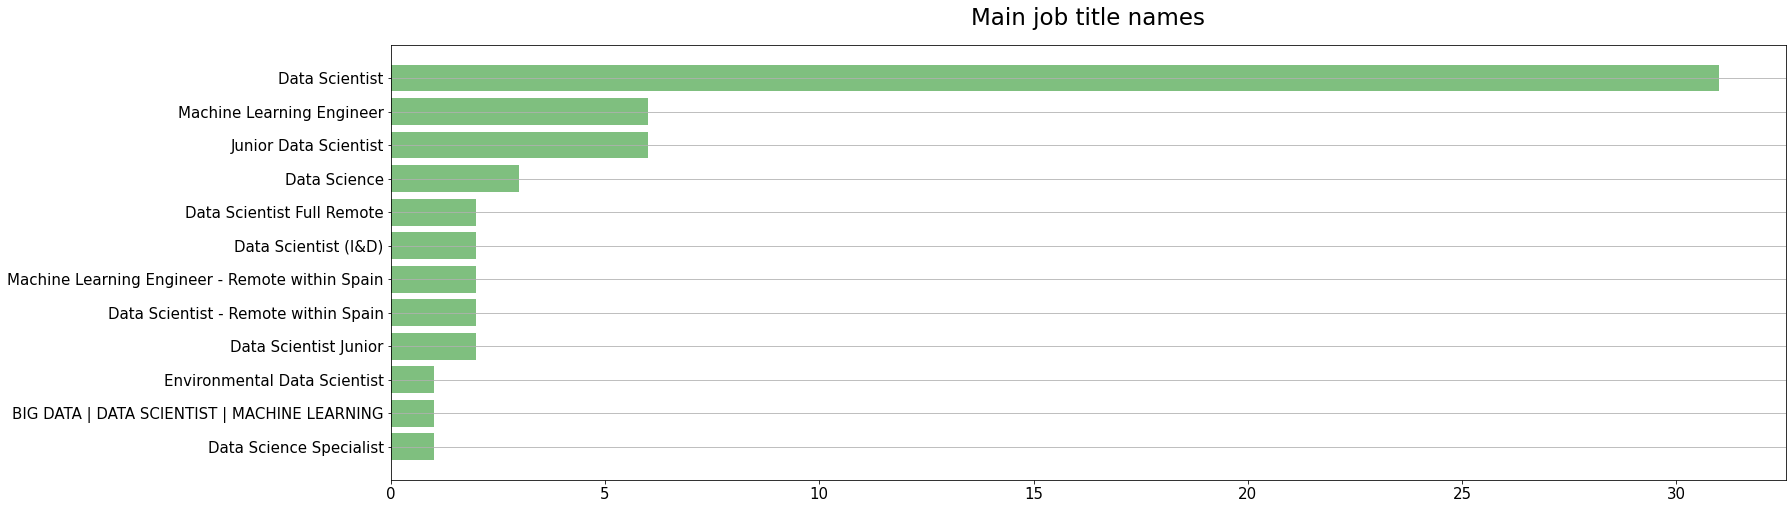

In [10]:
titles = jobs_df.job_title.value_counts()[:12].sort_values()
fig,ax = plt.subplots(figsize=(25,8))
plt.title("Main job title names", fontsize = 23, pad = 20)
plt.barh(y = titles.index, width = titles.values, color = "g", alpha = 0.5)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(axis = "y")
plt.show()

In [11]:
jobs_df.job_title = jobs_df.job_title.str.lower()

In [12]:
ds_jobs = jobs_df[(jobs_df.job_title.str.contains(job_search.title().lower())) | (jobs_df.job_title.str.contains("científico de datos"))]
ds_jobs.reset_index(inplace = True)
ds_jobs.head()

,ID,website,job_title,company,work_time,location,post_date,body
0,0,https://es.linkedin.com/jobs/view/data-scienti...,data scientist,Fever,Jornada completa,Madrid,Hace 6 días,"Hi, we're Fever\n\nWe're excited you are check..."
1,1,https://es.linkedin.com/jobs/view/data-scienti...,data scientist - remote within spain,Mad Collective,Jornada completa,Barcelona,Hace 2 días,At Mad Collective we are proud of our diversit...
2,2,https://es.linkedin.com/jobs/view/data-scienti...,data scientist,IRIUM,Jornada completa,Madrid,Hace 6 días,En IRIUM nos preocupamos porque no dejes de pe...
3,4,https://es.linkedin.com/jobs/view/data-scienti...,data scientist junior,SERIKAT,Jornada completa,Madrid,Hace 6 días,"¡En SERIKAT te estamos buscando! Actualmente, ..."
4,5,https://es.linkedin.com/jobs/view/data-scienti...,data scientist,Montarelo Consulting,Jornada completa,Madrid,Hace 3 días,The company: our customer Jungheinrich (JDS) i...


In [13]:
print(f"""
In this case we got {ds_jobs.shape[0]} Data science job offers""")


In this case we got 82 Data science job offers


#### 4.2 Language Normalization
- Since there are different idioms in results, we need to translate everything to a common language, in this case English. <br>
- To do that, we are going to make a flag, detecting the language of every *body*, and translate everyone that is not "en".

In [14]:
gtrans = googletrans.Translator()
ptrans = python_translator.Translator()

In [15]:
def lang_detect(row):
    return detect(row)

def translation(row):
    return gtrans.translate(row, dest = "en").text

In [16]:
ds_jobs["lang"] = ds_jobs.body.apply(lang_detect)

In [17]:
ds_jobs["lang"].value_counts()

es    44
en    38
Name: lang, dtype: int64

In [18]:
ds_jobs["body_en"] = np.where(ds_jobs["lang"] != "en",
                              ds_jobs.body.apply(ptrans.translate,source_language="es",target_language="en"),
                              ds_jobs.body)

In [19]:
ds_jobs[ds_jobs["body_en"].isnull() ==True]

,ID,website,job_title,company,work_time,location,post_date,body,lang,body_en
8,10,https://es.linkedin.com/jobs/view/data-scienti...,data scientist,Endesa,Jornada completa,Madrid,Hace 6 días,¿Qué se hace en la Business Line y en la unida...,es,None
13,16,https://es.linkedin.com/jobs/view/junior-data-...,junior data scientist,MIOTI Data Consulting Services,Jornada completa,Madrid,Hace 3 días,Descripción de la empresa\n\n¿Quienes somos? ‍...,es,None
20,23,https://es.linkedin.com/jobs/view/junior-data-...,junior data scientist,TECNALIA Research & Innovation,NaN,Derio,Hace 2 semanas,TECNALIA\n¡¡Anímate y únete a TECNALIA!! En TE...,es,None
27,30,https://es.linkedin.com/jobs/view/junior-data-...,junior data scientist,TECNALIA Research & Innovation,Jornada completa,Derio,Hace 1 mes,En TECNALIA queremos reforzar nuestro equipo d...,es,None
29,32,https://es.linkedin.com/jobs/view/data-scienti...,data scientist- machine learning engineer,MANGO,Jornada completa,Palau-solità i Plegamans,Hace 2 días,Estamos buscando un/a Machine Learning Enginee...,es,None
41,46,https://es.linkedin.com/jobs/view/data-scienti...,data scientist,PVD Engineering,Jornada completa,Alcobendas,Hace 1 día,Centro de Servicios a Tienda y Desarrollo de N...,es,None


- Using *python_translator* may not be enough to achieve our goal (it would be possible to get some fields without translation).
- So we can use *googletrans* for back up. The negative point is that is lower.

In [20]:
ds_jobs["body_en"] = np.where(ds_jobs["body_en"].isnull() == True,
                              ds_jobs.body.apply(translation),
                              ds_jobs.body_en)

#### 4.3 Tokenizing Body
The idea is to split the text of every publication in list of sentences and words to see what we can find.

In [21]:
ds_jobs["body_en"] = ds_jobs["body_en"].astype("str")

In [22]:
ds_jobs["sent_tk"] = ds_jobs.body_en.str.lower().apply(nltk.sent_tokenize)

In [23]:
ds_jobs["word_tk"] = ds_jobs.body_en.str.lower().apply(nltk.word_tokenize)

#### 4.4 Removing Stopwords
Is a good idea to remove words that doesn't add statistical value to this exercise:

In [24]:
stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_es = nltk.corpus.stopwords.words('spanish')
stopwords = stopwords_en + stopwords_es

In [25]:
def filt_chars(row):
    text_edited = re.sub("[^a-zA-Zñíáéíóú]"," ",str(row)).split(" ")
    return list(filter(lambda x: x != "" and x != "object" and x != "dtype", text_edited))

def filt_stopw(row):
    return list(filter(lambda x: x not in stopwords, row))

In [26]:
ds_jobs["word_tk_sw"] = ds_jobs["word_tk"].apply(filt_chars)
ds_jobs["word_tk_sw"] = ds_jobs["word_tk_sw"].apply(filt_stopw)

#### 4.5 Lemmatization
* Lemmatization consists in chopping the end of the words but takes grammar into account. So, "good" and better" would be reduced to "good" because there is the same basic semantic unit behind these two words, even if their lettering differ completely.

In [27]:
lemmatizer = WordNetLemmatizer()

In [28]:
def lem(row):
    return [lemmatizer.lemmatize(word) for word in row]

In [29]:
ds_jobs["word_tk_sw_lem"] = ds_jobs["word_tk_sw"].apply(lem)

In [30]:
ds_jobs.head()

,ID,website,job_title,company,work_time,location,post_date,body,lang,body_en,sent_tk,word_tk,word_tk_sw,word_tk_sw_lem
0,0,https://es.linkedin.com/jobs/view/data-scienti...,data scientist,Fever,Jornada completa,Madrid,Hace 6 días,"Hi, we're Fever\n\nWe're excited you are check...",en,"Hi, we're Fever\n\nWe're excited you are check...","[hi, we're fever\n\nwe're excited you are chec...","[hi, ,, we, 're, fever, we, 're, excited, you,...","[hi, fever, excited, checking, job, offer, lea...","[hi, fever, excited, checking, job, offer, lea..."
1,1,https://es.linkedin.com/jobs/view/data-scienti...,data scientist - remote within spain,Mad Collective,Jornada completa,Barcelona,Hace 2 días,At Mad Collective we are proud of our diversit...,en,At Mad Collective we are proud of our diversit...,[at mad collective we are proud of our diversi...,"[at, mad, collective, we, are, proud, of, our,...","[mad, collective, proud, diversity, nationalit...","[mad, collective, proud, diversity, nationalit..."
2,2,https://es.linkedin.com/jobs/view/data-scienti...,data scientist,IRIUM,Jornada completa,Madrid,Hace 6 días,En IRIUM nos preocupamos porque no dejes de pe...,es,At IRIUM we care that you don't stop pursuing ...,[at irium we care that you don't stop pursuing...,"[at, irium, we, care, that, you, do, n't, stop...","[irium, care, n, stop, pursuing, dreams, get, ...","[irium, care, n, stop, pursuing, dream, get, r..."
3,4,https://es.linkedin.com/jobs/view/data-scienti...,data scientist junior,SERIKAT,Jornada completa,Madrid,Hace 6 días,"¡En SERIKAT te estamos buscando! Actualmente, ...",es,"At SERIKAT we are looking for you! Currently, ...","[at serikat we are looking for you!, currently...","[at, serikat, we, are, looking, for, you, !, c...","[serikat, looking, currently, need, hire, juni...","[serikat, looking, currently, need, hire, juni..."
4,5,https://es.linkedin.com/jobs/view/data-scienti...,data scientist,Montarelo Consulting,Jornada completa,Madrid,Hace 3 días,The company: our customer Jungheinrich (JDS) i...,en,The company: our customer Jungheinrich (JDS) i...,[the company: our customer jungheinrich (jds) ...,"[the, company, :, our, customer, jungheinrich,...","[company, customer, jungheinrich, jds, german,...","[company, customer, jungheinrich, jds, german,..."


#### 4.6 Remote or Presential
Creation of a feature that tries to understand if the job is remote or presential. In case there are not clues in the body, an *unknown* flag will be used.

In [31]:
def job_type(row):
    return list(filter(lambda x: x.lower() in ["remote", "remotely", "hybrid", "teleworking","presential","remoto","presencial"],row))

In [32]:
ds_jobs["remote_presencial"] = ds_jobs.loc[:,"word_tk_sw_lem"].apply(job_type)

In [33]:
ds_jobs["remote_presencial"] = np.where(pd.Series(map(len,ds_jobs["remote_presencial"])) == 0,
                                ds_jobs.loc[:,"job_title"].apply(nltk.word_tokenize).apply(job_type),
                                ds_jobs["remote_presencial"])

In [34]:
def max_value(row):
    if len(row) == 0:
        return "unknown"
    else:
        return nltk.FreqDist(row).max()

In [35]:
ds_jobs["remote_presencial"] = ds_jobs["remote_presencial"].apply(max_value)

In [36]:
ds_jobs["remote_presencial"] = ds_jobs["remote_presencial"].str.replace("remoto","remote").str.replace("remotely","remote").str.replace("teleworking","remote")

In [37]:
print(f"""
These are the findings: 

{ds_jobs["remote_presencial"].value_counts()}
""")


These are the findings: 

unknown    41
remote     25
hybrid     16
Name: remote_presencial, dtype: int64



### 5. ANALYSIS

#### 5.1 Classification and filtering.
1. I built a general classification of skills/keywords to get a global understanding.
2. Then I am going to create a field *reqs* filtering them to see what are the most requested.

In [38]:
requirements_class = {"machine learning":"area", "data science toolkits":"area", "deep learning":"area", "python":"coding language", 
                      "sql":"data base", "mysql":"data base", "postgresql":"data base", "nosql":"data base", "mongodb":"data base", 
                      "hbase":"data base", "pyspark":"library", "jupiter":"software", "jupiter notebook":"software", "aws":"software", 
                      "neural networks":"model", "docker":"software", "clustering":"model", "artificial inteligence":"area", "scikit":"library", 
                      "statistical":"area", "statistics":"area", "ingles":"languages", "spanish":"languages", "matlab":"software", 
                      "r":"coding language", "pytorch":"library", "keras":"library", "data analytics":"area", "analytics":"area", 
                      "azure":"software", "colab":"software", "google colab":"software", "numpy":"library", "pandas":"library", 
                      "tensorflow":"library", "matplotlib":"library", "plotly":"library", "forecasting":"model", "classification":"model", 
                      "regression":"model", "decision trees":"model", "random forest":"model", "engineering":"education", "mathematics":"area", 
                      "physics":"area", "master":"education", "phd":"education", "computer science":"education", "italian":"languages", 
                      "data visualization":"area", "pipeline":"model", "etl":"area", "big data":"area", "frameworks":"area",  "kpi":"area",
                      "natural processing language":"model", "a/b testing":"area", "confussion matrix":"model", "powerbi":"software", 
                      "tableau":"software", "linux":"software", "git":"coding language", "hive":"data base", "scala":"coding language", 
                      "kubernetes":"software"}

In [39]:
def filt_reqs(row):
    return list(filter(lambda x: x in requirements_class.keys(), row))

In [40]:
ds_jobs["reqs"] = ds_jobs["word_tk_sw_lem"].apply(filt_reqs)

In [41]:
ds_jobs["reqs"]

0     [engineering, engineering, engineering, engine...
1     [statistical, statistical, statistical, engine...
2     [statistical, mathematics, statistical, engine...
3                  [engineering, etl, python, sql, etl]
4     [analytics, analytics, analytics, python, r, a...
                            ...                        
77    [r, mathematics, engineering, linux, statistical]
78    [analytics, analytics, analytics, sql, python,...
79    [statistical, mathematics, analytics, r, pytho...
80    [statistical, analytics, analytics, mathematic...
81                               [python, r, analytics]
Name: reqs, Length: 82, dtype: object

In [42]:
reqs_len = pd.Series(map(len,ds_jobs["reqs"]))

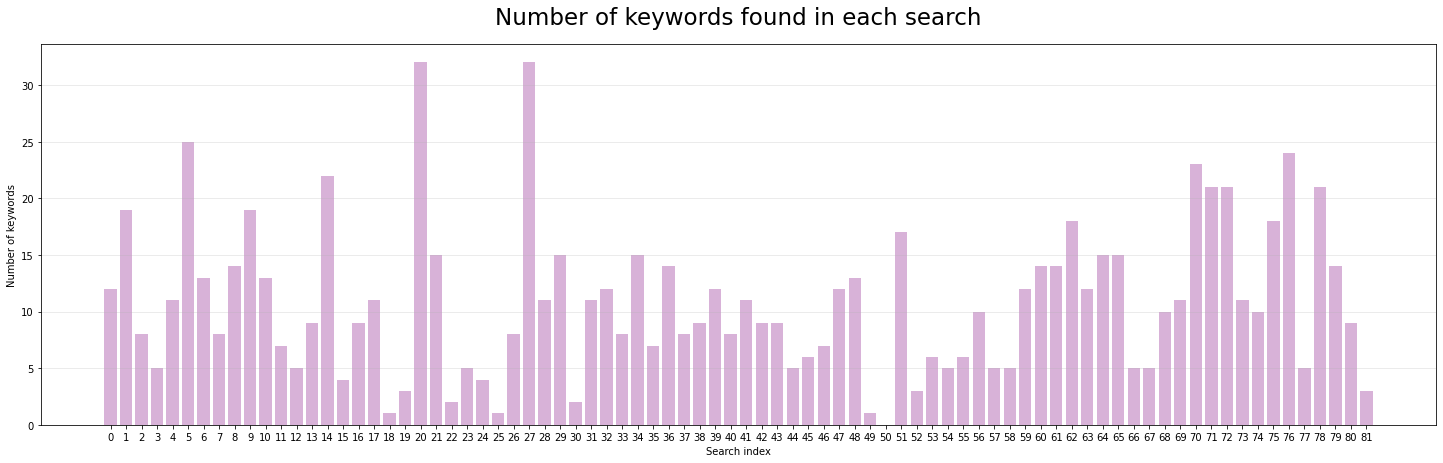

In [43]:
fig,ax = plt.subplots(figsize = (22,7))
plt.bar(x = reqs_len.index, height = reqs_len, color = "purple", alpha = 0.3)
plt.title("Number of keywords found in each search", fontsize = 23, pad = 20)
plt.xlabel("Search index")
plt.ylabel("Number of keywords")
plt.grid(True, axis="y", alpha = 0.3)
plt.xticks(ticks = np.arange(0,ds_jobs["reqs"].size,1))
plt.show()

In [44]:
print(f"""Site without requirements keywords: {reqs_len[reqs_len == 0].index.values}

Search content: {ds_jobs["word_tk_sw_lem"][reqs_len[reqs_len == 0].index].values}
""")


Site without requirements keywords: [50]

Search content: [list(['hh', 'hunter', 'looking', 'data', 'scientist', 'join', 'one', 'main', 'client', 'madrid', 'function', 'data', 'analysis', 'treatment', 'creation', 'synthetic', 'variable', 'development', 'test', 'integration', 'process', 'extraction', 'business', 'conclusion', 'ability', 'estimate', 'effort', 'deadline', 'achievement', 'objective', 'committed', 'ensures', 'compliance', 'communication', 'client', 'including', 'agreement', 'monitoring', 'objective', 'acceptance', 'criterion', 'team', 'coordination', 'identify', 'redirect', 'problematic', 'situation', 'arise', 'throughout', 'project', 'may', 'pose', 'risk', 'achievement', 'objective', 'need', 'least', 'year', 'experience', 'position', 'offer', 'offer', 'competitive', 'salary', 'sector', 'indefinite', 'contract', 'possibility', 'teleworking', 'day', 'contact', 'u'])]



#### 5.2 Word Frequency
It's time to count words of keywords and body fields, to make stats with them.

In [45]:
ds_jobs["word_tk_sw_lem_freq"] = ds_jobs["word_tk_sw_lem"].apply(nltk.FreqDist)
ds_jobs["reqs_freq"] = ds_jobs["reqs"].apply(nltk.FreqDist)

In [46]:
ds_jobs["word_tk_sw_lem_freq"].head()

0    {'hi': 1, 'fever': 15, 'excited': 1, 'checking...
1    {'mad': 2, 'collective': 2, 'proud': 1, 'diver...
2    {'irium': 4, 'care': 1, 'n': 1, 'stop': 1, 'pu...
3    {'serikat': 1, 'looking': 2, 'currently': 1, '...
4    {'company': 2, 'customer': 3, 'jungheinrich': ...
Name: word_tk_sw_lem_freq, dtype: object

In [47]:
ds_jobs["reqs_freq"].head()

0    {'engineering': 5, 'analytics': 1, 'phd': 1, '...
1    {'statistical': 5, 'engineering': 2, 'phd': 1,...
2    {'statistical': 2, 'mathematics': 1, 'engineer...
3    {'engineering': 1, 'etl': 2, 'python': 1, 'sql...
4    {'analytics': 4, 'python': 1, 'r': 1, 'azure':...
Name: reqs_freq, dtype: object

#### 5.3 DF Summary and charts

In [48]:
requirements_class_df = pd.DataFrame(data = requirements_class.values(), index = requirements_class.keys()).reset_index()
requirements_class_df.rename(columns = {"index":"reqs",0:"req_class"}, inplace = True)

In [49]:
requirements_class_df.head()

,reqs,req_class
0,machine learning,area
1,data science toolkits,area
2,deep learning,area
3,python,coding language
4,sql,data base


In [50]:
top_skills_df = pd.DataFrame(index = ds_jobs.reqs_freq.sum().keys(), data = ds_jobs.reqs_freq.sum().values()).reset_index()
top_skills_df.rename(columns = {"index":"reqs",0:"skills_freq"}, inplace = True)
top_skills_df = top_skills_df.sort_values(by = "skills_freq",ascending=False)

In [51]:
top_skills_df = pd.merge(top_skills_df,requirements_class_df, how="left", on ="reqs")
top_skills_df = top_skills_df[["reqs","req_class","skills_freq"]]

In [52]:
top_skills_df["percent_total"] = np.round(top_skills_df.skills_freq / top_skills_df.skills_freq.sum() *100,1)

In [53]:
top_skills_df.head()

,reqs,req_class,skills_freq,percent_total
0,analytics,area,114,12.8
1,python,coding language,97,10.9
2,engineering,education,85,9.6
3,statistical,area,63,7.1
4,mathematics,area,54,6.1


In [54]:
top_words_df = pd.DataFrame(index = ds_jobs["word_tk_sw_lem_freq"].sum().keys(), data = ds_jobs["word_tk_sw_lem_freq"].sum().values())
top_words_df.rename(columns = {0:"words_freq"}, inplace = True)
top_words_df = top_words_df.sort_values(by = "words_freq",ascending=False)

In [55]:
top_words_df.head()

,words_freq
data,724
experience,318
team,288
work,263
learning,244


In [56]:
top_words_df["percent_total"] = np.round(top_words_df.words_freq / top_words_df.words_freq.sum() *100,1)

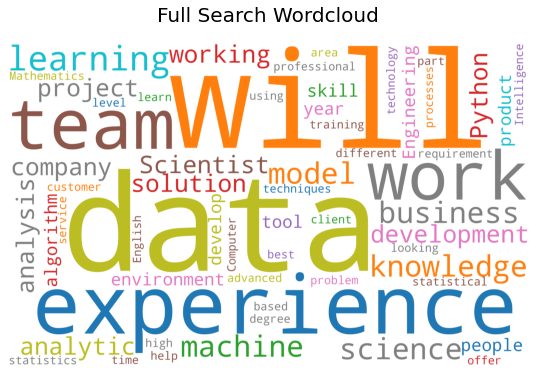

In [57]:
width=1600
height = 1000
full_body = re.sub("[^a-zA-Zñíáéíóú]"," ",ds_jobs.body_en.sum())

fig, ax = plt.subplots(figsize=(12,6))      
ax.set_title("Full Search Wordcloud", fontsize = 20, pad = 20)
wordcloud_body = WordCloud(background_color="white", max_words=60, regexp = None, scale = 5, width=width, height = height,
                      contour_width=0.0001, contour_color = "lightgray", normalize_plurals = True,
                      min_word_length = 4, relative_scaling=0, include_numbers = True,
                      mode = "RGB", colormap = "tab10", collocations = False, random_state = 150240).generate(full_body)

ax.imshow(wordcloud_body, interpolation='bilinear')
wordcloud_body.to_file("wordcloud_body.png")
ax.axis("off")
plt.show()

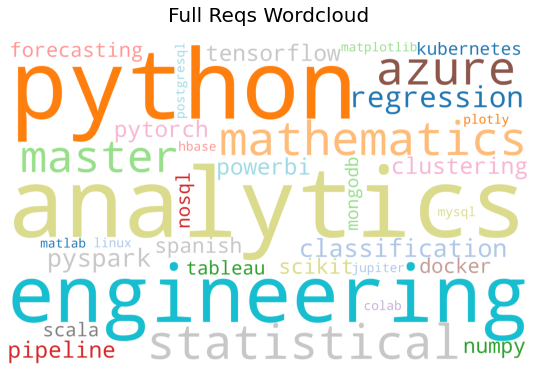

In [58]:
full_reqs = " ".join(ds_jobs["reqs"].sum())

fig, ax = plt.subplots(figsize=(12,6))      
ax.set_title("Full Reqs Wordcloud", fontsize = 20, pad = 20)
wordcloud_skills = WordCloud(background_color="white", max_words=80, regexp = None, scale = 5, width=width, height = height,
                      contour_width=0.0001, contour_color = "lightgray", normalize_plurals = True,
                      min_word_length = 5, relative_scaling=0, include_numbers = True,
                      mode = "RGB", colormap = "tab20", collocations = False, random_state = 150240).generate(full_reqs)

ax.imshow(wordcloud_skills, interpolation='bilinear')
wordcloud_skills.to_file("wordcloud_skills.png")
ax.axis("off")
plt.show()

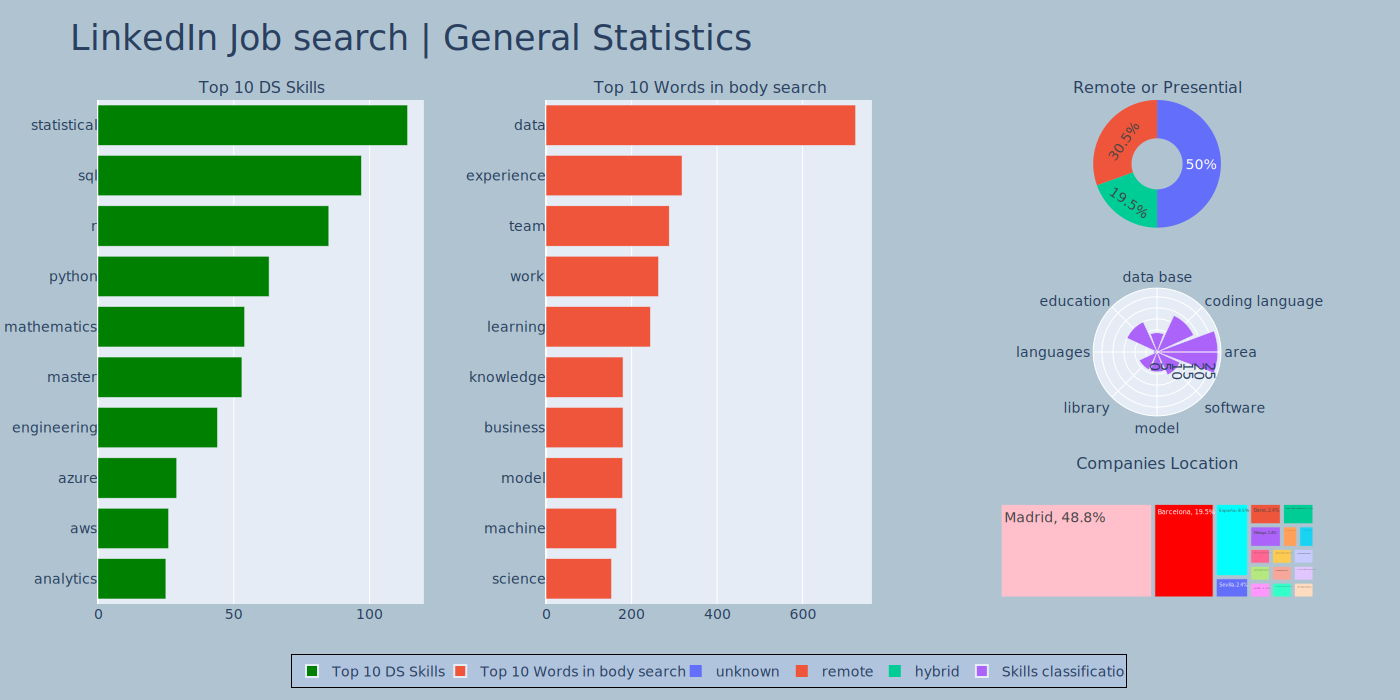

In [60]:
most_of_skills_n = top_skills_df.skills_freq[:10].sort_values()
most_of_skills = top_skills_df.reqs[:10].sort_values()
most_of_body = top_words_df.words_freq[:10].sort_values()
remote_pres = ds_jobs.remote_presencial.value_counts()
locs_count = ds_jobs.location.value_counts()
parents = [""]*len(locs_count)
req_class_prop = top_skills_df.groupby("req_class").sum().percent_total
#Treemap labels with city and percentage of appearence
tree_labels = []
for i,el in enumerate(locs_count.index):
    tree_labels.append(f"{el}, {np.round(locs_count/locs_count.sum()*100,1)[i]}%")

trace1 = go.Bar(name = "Top 10 DS Skills", y = most_of_skills, x = most_of_skills_n, orientation = "h", width = .8, marker=dict(color="green"))
trace2 = go.Bar(name = "Top 10 Words in body search", y = most_of_body.index, x = most_of_body, orientation = "h", width = .8, )
trace3 = go.Pie(labels=remote_pres.index, values=remote_pres.values, hole = 0.4)
# trace4 = go.Indicator(value=50,mode='gauge+number+delta')
trace5 = go.Treemap(name = "Companies Location", labels = tree_labels, parents = parents, values = locs_count.values, 
                    marker=dict(colors=["pink","red","cyan"]),)
trace6 = go.Barpolar(name = "Skills classification", r = req_class_prop, theta = req_class_prop.index,
                     marker = dict(showscale = False))

fig = make_subplots(rows=3,cols=3, horizontal_spacing = 0.1, vertical_spacing = 0.12,
                    specs=[[{"rowspan":3},{"rowspan":3},{"type":"pie"}],
                           [None,None,{"type":"polar"}],
                           [None,None,{"type":"treemap"}]],
                    subplot_titles = ("Top 10 DS Skills", "Top 10 Words in body search","Remote or Presential","", "Companies Location"))

fig.add_traces(data=trace1,rows=1,cols=1)
fig.add_traces(data=trace2,rows=1,cols=2)
fig.add_traces(data=trace3,rows=1,cols=3)
fig.add_traces(data=trace6,rows=2,cols=3)
fig.add_traces(data=trace5,rows=3,cols=3)

fig.update_layout(title = "LinkedIn Job search | General Statistics", title_font = dict(size = 35), font = dict(size = 14),  paper_bgcolor = '#AFC4D0',
                   height=700, width=1400, 
                   legend = dict(
                      orientation = "h",
                      bgcolor = "LightSteelBlue",
                      x = 0.5,
                      bordercolor = "Black",
                      borderwidth = 1,
                      itemsizing = "constant",
                      xanchor = "auto"))

fig.show('svg')

### 6. CONCLUSION

#### To conclude it's easy to see the following:
* Coding languages like *Python and r* are highly requested.
* It is valuable to have data bases skills like sql, azure and aws.
* Engineer education and a master degree are a must.
* Most of Spain oportunities are in Madrid (~50%) and Barcelona (~20%).
* There are plenty of publications that are not clear about the working place mode (home or office).
* Team work, experience, continuous learning and business intelligence are fundamental.